# 传播网络

## 导入模块

In [1]:
import os
import sys
import math
from collections import defaultdict
import numpy as np
import pandas as pd
import glob
import datetime
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
def StandardPlot(ax, fontsize=12, grid=True, ticks=True, left=True, right=True, top=True, bottom=True):
    font_label = {'family': 'arial', 'size': fontsize}
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('arial') for label in labels]
    if grid == True:
        ax.xaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.5, zorder=0)
        ax.yaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.5, zorder=0)
    if ticks == True:
        ax.tick_params(axis='x', direction='out',
                       color='k', labelsize=fontsize, pad=3)
        ax.tick_params(axis='y', direction='out',
                       color='k', labelsize=fontsize, pad=3)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    return ax

def linear_fit_plot_flight(X,Y,ax,x_pos=0.1,y_pos=0.8,fontsize = 12):
    data = pd.DataFrame({'x': X, 'y':Y})
    model = ols('y~x', data).fit()
    rho  = pearsonr(X, Y).statistic
    a,b = model.params['x'],model.params['Intercept']
    R2 = model.rsquared
    p_value = model.pvalues['x']
    x_line = sorted(X)
    y_line = a * np.array(x_line) + b
    p_test = float(model.pvalues['x'])
    ax.text(x_pos,y_pos, r'$\mathit{r}$=%.2f,' % (rho) +
             r'$\mathit{p}$' + r'<%.1f5' % (p_value), size=fontsize, fontdict={'family': 'arial'},transform=ax.transAxes)
    ax.plot(x_line, y_line, color='red', ls='-', linewidth=2, zorder=2)
    ax.scatter(X,Y,s = 80,color = '#00BFFF',edgecolor='#00688B',alpha =1,linewidths=1)
    return ax

def Correlation_flight_export_S2A(ax,df_net):
    df_flight = pd.read_csv('Overseas_flight_to_CN.csv',index_col=0)
    df_trans = df_net.groupby('s_country')['source'].count().reset_index().rename(columns = {'source':'trans'})
    df_plot = df_flight.merge(df_trans,left_on = 'Dep Country Name',right_on = 's_country',how = 'inner')
    X = df_plot['Total Est. Pax'].tolist()
    Y = df_plot['trans'].tolist()
    ax = linear_fit_plot_flight(X,Y,ax,fontsize=fontsize)
    return ax

def Correlation_flight_export_S2B(ax,df_net):
    df_flight= pd.read_csv('Overseas_flight_to_province.csv',index_col=0)
    df_trans = df_net.groupby(['s_country','t_prov'])['source'].count().reset_index().rename(columns = {'source':'trans'})
    df_plot = df_flight.merge(df_trans,left_on = ['Dep Country Name','arr_prov'],right_on = ['s_country','t_prov'],how = 'inner')
    X = df_plot['Total Est. Pax'].tolist()
    Y = df_plot['trans'].tolist()
    ax = linear_fit_plot_flight(X,Y,ax,fontsize=fontsize)
    return ax

def linear_fit_plot_sensitive(X,Y,ax,x_pos=0.1,y_pos=0.8,fontsize = 12):
    data = pd.DataFrame({'x': X, 'y':Y})
    model = ols('y~x', data).fit()
    rho  = pearsonr(X, Y).statistic
    a,b = model.params['x'],model.params['Intercept']
    R2 = model.rsquared
    p_value = model.pvalues['x']
    x_line = sorted(X)
    y_line = a * np.array(x_line) + b
    p_test = float(model.pvalues['x'])
    if p_value<=0.05:
        ax.plot(x_line, y_line, color='red', ls='-', linewidth=2, zorder=2)
        ax.scatter(X,Y,s = 80,color = '#CDC9C9',edgecolor='black',alpha =0.7,linewidths=2)
        ax.text(x_pos,y_pos, r'$\mathit{r}$=%.2f,' % (rho) +
                 r'$\mathit{p}$' + r'<0.05' , size=fontsize, fontdict={'family': 'arial'},transform=ax.transAxes)
    else:
        ax.plot(x_line, y_line, color='grey', ls='--', linewidth=2, zorder=2)
        ax.scatter(X,Y,s = 80,color = '#CDC9C9',edgecolor='black',alpha =1,linewidths=1)
        ax.text(x_pos,y_pos, r'$\mathit{r}$=%.2f,' % (rho) +
                 r'$\mathit{p}$' + r'=%.1f5' % (p_value), size=fontsize, fontdict={'family': 'arial'},transform=ax.transAxes)
    return ax

def seq_export_number(lineage,metafile,transfile,fig_outfile=None):
    prov_lst = ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou',
                'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Jiangsu',
                'Jiangxi', 'Jilin', 'Liaoning', 'Neimenggu', 'Ningxia', 'Qinghai',
                'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Xinjiang', 'Xizang', 'Yunnan', 'Zhejiang']
    df = pd.read_csv(metafile)
    df_l = df[df['Omicron sublineages'].isin([lineage]) & df['Province'].isin(prov_lst)]
    lineage_prov_lst= df_l.Province.unique().tolist()
    prov_seq_dct = dict(df_l.Province.value_counts())
    df_trans = pd.read_csv(transfile, index_col=0).reindex(lineage_prov_lst).sort_values(by='export', ascending=False)
    X_trans = df_trans.index.tolist()
    Y_trans = df_trans.export.tolist()
    Y = []
    for x in X_trans:
        Y.append(prov_seq_dct[x])
    plt.rcParams['pdf.fonttype'] = 42
    fontsize = 16
    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(2, 2, width_ratios=[4, 2], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.bar(X_trans, Y_trans, color='indianred')
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.bar(X_trans, Y, color='royalblue')
    ax3 = fig.add_subplot(gs[0:2, 1])
    ax3 = linear_fit_plot_sensitive(Y, Y_trans, ax=ax3,fontsize= fontsize)
    ax1.set_ylabel('exports',{'family': 'arial', 'size': fontsize})
    ax2.set_ylabel('sequences',{'family': 'arial', 'size': fontsize})
    ax3.set_xlabel('sequences',{'family': 'arial', 'size': fontsize})
    ax3.set_ylabel('exports',{'family': 'arial', 'size': fontsize})
    for axi in [ax1, ax2,ax3]:
        labels = axi.get_xticklabels() + axi.get_yticklabels()
        [label.set_fontname('arial') for label in labels]
    ax1.set_xticks([])
    ax1.tick_params(axis='x', direction='out',color='k', labelsize=fontsize, pad=3)
    ax1.tick_params(axis='y', direction='out',color='k', labelsize=fontsize, pad=3)
    ax2.tick_params(axis='x', direction='out',labelsize=fontsize-4, rotation=90)
    ax2.tick_params(axis='y', direction='out',labelsize=fontsize)
    ax3.tick_params(axis='x', direction='out',labelsize=fontsize, rotation=90)
    ax3.tick_params(axis='y', direction='out',labelsize=fontsize)
    fig.suptitle(lineage,fontsize=fontsize+4)
    plt.tight_layout()

## Association between international air travel volume and SARS-CoV-2 importation into the mainland of China

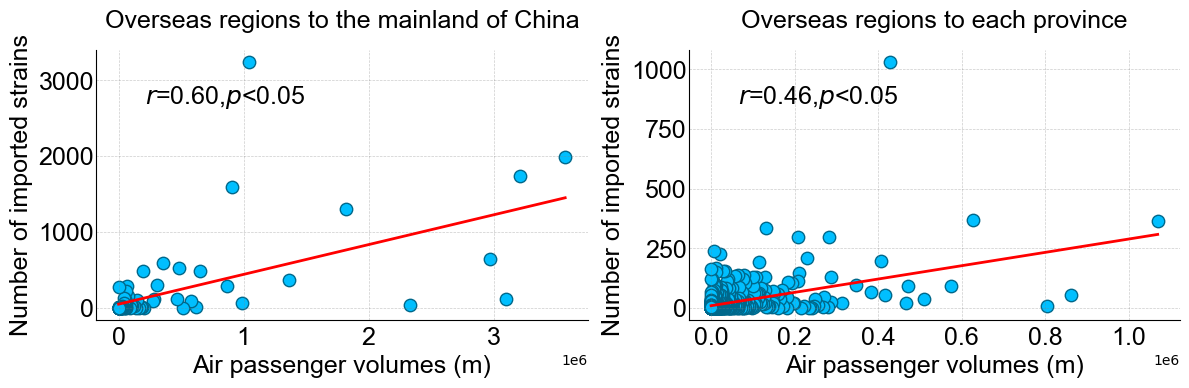

In [3]:
prov_lst = ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou','Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Jiangsu',
            'Jiangxi', 'Jilin', 'Liaoning', 'Neimenggu', 'Ningxia', 'Qinghai',
              'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Xinjiang', 'Xizang', 'Yunnan', 'Zhejiang']
dominant_Omicron_sublineages = [ 'BA.5','BF.7', 'DY','XBB','EG.5','HK']
df_net_lst = []
for lineage in dominant_Omicron_sublineages:
    df_neti = pd.read_csv('../results/mutnet/Overseas_%s_network.csv' % lineage)
    df_net_lst.append(df_neti)
df_net = pd.concat(df_net_lst)
fig, ax = plt.subplots(1,2,figsize=(12, 4))
plt.rcParams['pdf.fonttype'] = 42
fontsize=18
ax_array = ax.flatten()
ax1 = ax_array[0]
ax2 = ax_array[1]
ax1 = Correlation_flight_export_S2A(ax1,df_net)
ax2 = Correlation_flight_export_S2B(ax2,df_net)
for axi in ax_array:
    axi = StandardPlot(axi,fontsize = fontsize,grid = True,right = False,top = False)
    axi.tick_params(axis='y', direction='out',color='white', labelsize=fontsize, pad=-2)
    axi.tick_params(axis='x', direction='out',color='white', labelsize=fontsize, pad=1,rotation = 0)
    axi.set_xlabel('Air passenger volumes (m)',{'family': 'arial', 'size': fontsize})
    axi.set_ylabel('Number of imported strains',{'family': 'arial', 'size': fontsize})
ax1.set_title('Overseas regions to the mainland of China',{'family': 'arial', 'size': fontsize},y = 1.05)
ax2.set_title('Overseas regions to each province',{'family': 'arial', 'size': fontsize},y = 1.05)
plt.tight_layout()

## Provincial transmission dynamics of Omicron sublineages following subsampling (BA.5)

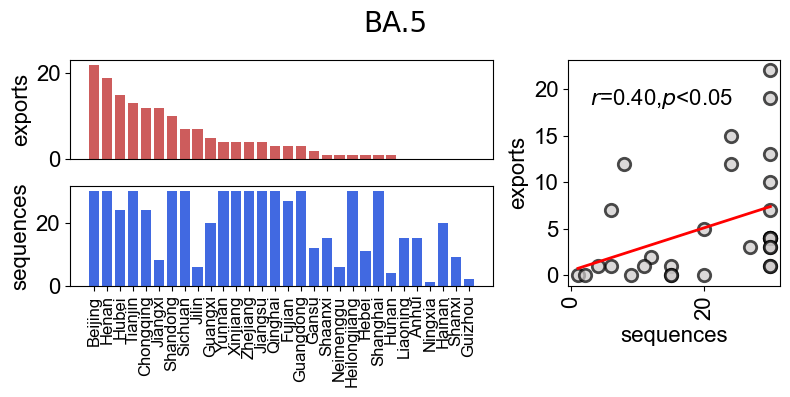

In [4]:
lineage = 'BA.5'
metafile = '../data/sensitive_analysis/cdhit/sample/%s.csv' % lineage
outfile_trans = '../results/sensitive_analysis/cdhit/result/%s_trans.csv' % lineage
fig_outfile = '../results/sensitive_analysis/figure/%s.pdf' % lineage
seq_export_number(lineage, metafile, outfile_trans,fig_outfile = fig_outfile)